# Encontro 08

## Materiais de apoio:

* The Scientist and Engineer's Guide to Digital Signal Processing, de By Steven W. Smith, Ph.D. (capítulo 27)
	* Disponível em http://www.dspguide.com

## Tópicos Abordados:

* Conceitos de Compactação/Compressão de Dados:
  * Conceito geral e usos;
  * Tipos de compactação:
    * Sem perdas (lossless);
    * Com perdas (lossy).
  * Algoritmos comuns:
    * Codificação Run-Length;
    * Codificação Huffman;
    * Codificação Delta;
    * CS&Q (amostragem e/ou quantização grosseira).
  * Compactação de dados genéricos;
  * Compactação de áudio;
  * Compactação de imagens;

* Compactação/Compressão de dados em Python:
  * Pacote LMZA;

* Exemplos de aplicações:
  * Compactação e descompactação de um sinal genérico;
  * Importação e compactação de arquivo de texto;
  * Importação e exportação de arquivos compactados;
  * Descompactação e exportação de arquivo de texto;
  * Compactação incremental de dados.


In [1]:
# Importação de módulos e instalação de bibliotecas adicionais

# Importação do pacote matématico Math
import math

# Importação do pacote Pandas
import pandas as pd

# Importação dos pacotes NumPy e SciPy
import numpy as np
from scipy.interpolate import interp1d, interp2d
from scipy import signal, misc, ndimage

# Importação do pacote skimage e alguns componentes
import skimage as skimg
from skimage import morphology
from skimage import feature

# Importação do pacote librosa e alguns componentes
import librosa
import librosa.display

# Importação do pacote LZMA
import lzma

# Importação do pacote SoundFile
!pip install soundfile
import soundfile as sf

# Importação do pacote Padasip
!pip install padasip
import padasip as pa

# Importação do pacote IPython.display
import IPython.display as ipd

# Importação de Widgets
import ipywidgets as widgets

# Importação do pacote PyPlot do MatPlotLib
import matplotlib.pyplot as plt

# Instalação e importação do pacote mpld3
!pip install mpld3
import mpld3

# importação do módulo timeit
import timeit

  Created wheel for padasip: filename=padasip-1.1.1-cp36-none-any.whl size=52974 sha256=a4672a7188ad6ac8ca1c8789971c44bf7330f46ab1f1bf34c84a867ca6841669
  Stored in directory: /root/.cache/pip/wheels/64/33/7b/3fe5f0377cb1d58f8f565dc0e718ae80767f8f563e6a77f1ac
Successfully built padasip
     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364064 sha256=60300bbf7bbd9caa1db0f684cf5fa4b14fee3ca0279fbb0007ae967b09ae62fd
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3


In [2]:
# Diretiva do Notebook para exibição de gráficos inline
%matplotlib inline

# Configuração do tamanho dos gráficos
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
# Importação de dados do Google Drive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

filepath = 'My Drive/Colab Notebooks/pae_maua/encontro_08/'

Mounted at /gdrive
/gdrive


## Conceitos de Compactação/Compressão de Dados

### Conceito geral e usos

É comum ser necessário armazenar ou então transmitir dados em sistemas digitais. No entanto, tanto o armazenamento quanto a transmissão de dados envolvem custos operacionais. Para minimizar esses custos, foram desenvolvidos algoritmos de compactação/compressão de dados.

Existem diversos algoritmos de compactação, mas tem todo o mesmo objetivo: representar uma informação da maneira mais compacta (ocupando a menor quantidade de bits) possível. É importante observar que dificilmente uma informação compactada pode ser usada para processamento, de forma que é necessário sempre realizar a compactação ou descompactação dos dados antes e depois de um processamento.

Essa classe de algoritmos é de extrema importância no mundo atual, pois permite um tráfego maior de informações nas vias de telecomunicações (como telefonia ou internet).


### Tipos de compactação

Podemos genericamente classificar algoritmos de compactação de dados em duas classes: sem perdas e com perdas.


#### Sem perdas (lossless)

Algoritmos sem perdas (também conhecidos como lossless) são algoritmos que buscam compactar os dados sem perda da informação original. Isso é, a nova representação da informação deve conter exatamente a mesma quantidade de informação da representação original.

São usualmente baseados em encontrar padrões e repetições nos dados a serem compactados, usando essa informação para armazenar a mesma informação em menos bits. Assim, sua capacidade e limite de compactação depende diretamente do dado sendo compactado. Normalmente tem péssimo desempenho para dados aleatórios (gerando representações maiores que a original).

A vantagem de métodos sem perdas é que a informação compactada pode ser descompactada (retornada a sua representação original). Dessa forma ele é apropriado para o armazenamento de qualquer tipo de dado em que não se possa ter introdução de ruídos ou erros (por exemplo, executáveis, arquivos de textos, bancos de dados, dados numéricos, etc.).



#### Com perdas (lossy)

Algoritmos com perdas (também conhecidos como lossy) são algoritmos que buscam compactar dados admitindo perda e degradação da informação. Isso é, a nova representação da informação não precisa conter exatamente a mesma quantidade de informação da representação original.

Podem se utilizar de diversas técnicas diferentes para obter o resultado desejado, mas normalmente se baseiam em descartar parte das informações originais (em especial informações consideradas de baixa importância ou impacto). Sua capacidade de compactação depende mais de quanta informação se está disposto a descartar do que da natureza da informação em si. Devido a isso, conseguem bom desempenho mesmo com dados aleatórios.

A vantagem desse tipo de compactação é são os grandes fatores de compactação que se pode atingir. No entanto, não é possível descompactar os dados (reconstruir a representação original). Dessa forma ele é apropriado apenas para o armazenamento de dados que admitam degradações, como ruídos ou erros (por exemplo, imagens, áudios, vídeos, sinais temporais, etc.).


### Algoritmos comuns


#### Codificação Run-Length

O algoritmo Run-Length é um algoritmo de comparação sem perdas particularmente útil para dados com grandes repetições de dados. Por exemplo, um sinal com grande quantidade de amostras zeros ou uma imagem com áreas grandes de uma única cor.

Existem diversos esquemas de Run-Length, mas eles são baseados em armazenar áreas contíguas de dados repetidos (por exemplo, uma serie longa de 0s) de uma maneira compacta. Geralmente como o valor e a quantidade de vezes que ele é repetido.

Um bom exemplo geral de um algoritmo de Run-Length é o PackBits. No PackBits, cada byte (8 bits) do arquivo original é substituído por 9 bits, com o novo bit representando o sinal do valor. Valores positivos representam um dado e valores negativos representam a repetição desse dado. Por exemplo, uma sequência `1,2,3,4,2,2,2,2,4` seria representada como `1,2,3,4,2,-3,4`. Um exemplo melhor pode ser visto na imagem abaixo. Essa codificação só é eficiente para arquivos com grandes repetições de valores seguidos.


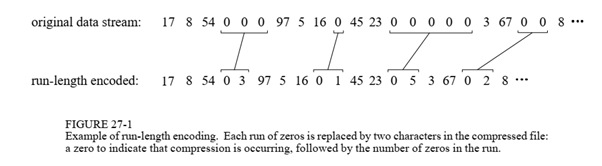

#### Codificação Huffman

Nomeado em homenagem a D.A. Huffman, que desenvolveu o procedimento nos anos de 1950, é um método baseado na detecção de concentração de valores.

Por exemplo, em arquivos de texto muito longos, temos mais de 96% do arquivo consistindo apenas de 31 caracteres: as letras minúsculas, o espaço, a virgula, o ponto e o identificador de linha.

Usando essa informação, é possível armazenar esses 31 caracteres com uma forma mais compacta (as custas de armazenar todos os outros caracteres de uma maneira menos compacta) e obter uma redução no tamanho do arquivo. Um histograma de um arquivo de texto grande pode ser visto na imagem abaixo.


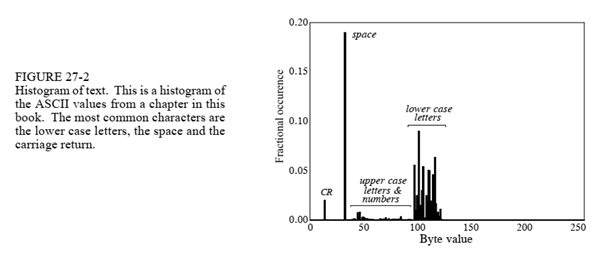

A codificação de Huffman usa esse mesmo conceito de concentração de valores para mudar a representação dos dados originais. Analisando o arquivo original, é possível verificar qual a probabilidade de ocorrência de um determinado byte ou caráter. Representando os bytes ou caracteres com maior probabilidade de maneira mais reduzida (um único bit para o byte ou caráter mais provável) e bytes ou caracteres com menor probabilidade de maneiras menos reduzidas (podendo ser mais que 8 bits), é possível atingir boa compactação para dados com alta concentração. Pode se observar um exemplo dessa codificação na imagem abaixo.

Um método mais avançado da codificação de Huffman é a Codificação Aritmética, que usa o mesmo conceito, mas com códigos diferentes.


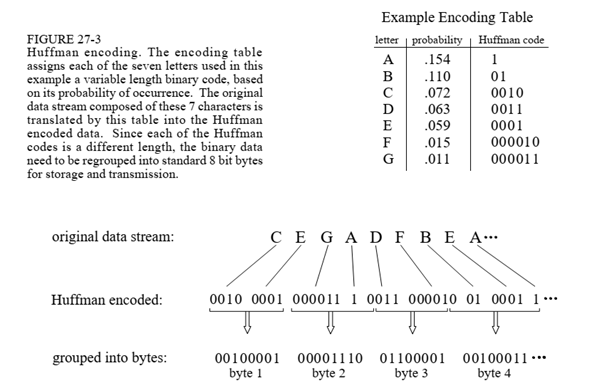

#### Codificação Delta

A codificação delta é uma técnica simples de compactação que é particularmente útil para sinais temporais e dados com variações baixas ou contínuas.

Nessa codificação, cada valor é representado como a diferença para o valor anterior, e não pelo seu valor absoluto. Um exemplo dessa codificação pode ser visto na imagem abaixo.


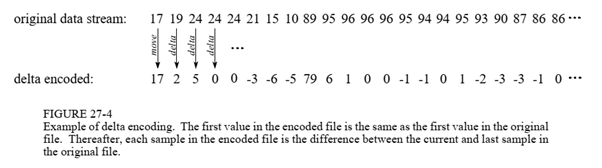

Por si só essa codificação não consegue reduzir o tamanho de uma representação, mas para sinais com variação lenta ou contínua, ele gera uma representação com alta concentração de amostras. Ou seja, um sinal ideal para a codificação Huffman ter bons resultados. Um exemplo da concentração criada pode ser visto na imagem abaixo.

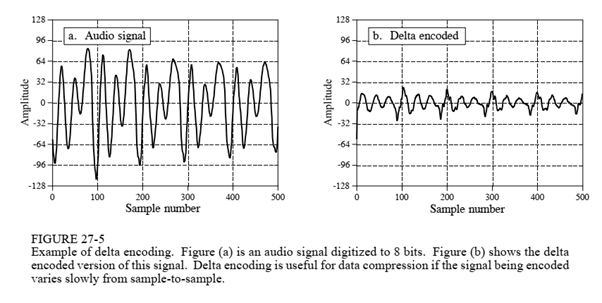

#### Compactação CS&Q (amostragem e/ou quantização grosseira)

O algoritmo CS&Q, também conhecido como amostragem e/ou quantização grosseira é um algoritmo com perdas particularmente útil para sinais temporais.

Ele pode ser considerado a forma mais simples de uma compactação com perdas e é baseado em descarte de amostras (modificação da amostragem) ou em quantização do sinal (modificação da quantização). Por exemplo: podemos reduzir a quantidade de dados descartando metade das amostras de um sinal ou fazendo todos os valores serem quantizados em intervalos menores.


### Compactação de dados genéricos

Quando se deseja compactar um dado genérico, onde não é conhecida a natureza específica dos dados, assume-se que os dados não admitem perdas e são usados métodos sem perdas (lossless).

Existem diversos formatos e algoritmos sem perdas disponíveis para utilização, gratuitamente ou não. A maioria desses algoritmos é de alta complexidade, sendo uma combinação de algoritmos comuns e proprietários. 

Alguns dos algoritmos mais comumente usados são:
* ZIP;
* LZMA;
* RAR;
* TAR, GZIP e BZIP2.



### Compactação de áudio

A compactação de áudio depende muito do objetivo e uso final do áudio. Por exemplo, uma música de alta qualidade deve ser tratada diferente do que uma voz para ser transmitida para telecomunicação.

No geral, a informação de áudio admite perda de informação (um som pode ser de baixa qualidade e ainda conter a mensagem correta) permitindo grandes compactações. Existem diversas técnicas e algoritmos de compactação, mas são usualmente baseados em descartar frequências não audíveis, redução de amostras, aumento de quantização e aproveitamento da sensibilidade logarítmica do ouvido.

Dando enfoque no armazenamento e reprodução de música de alta fidelidade, temos como algoritmos mais comuns:

Com perdas:
* AAC (Advanced Audio Coding);
* MP3 (MPEG-1 Audio Layer 3);
* OGG;
* WMA (Windows Media Audio).

Sem perdas e com compactação:
* ALAC (Apple Lossless Audio Codec);
* FLAC (Free Lossless Audio Codec);
* WMA (Windows Media Audio).

Sem perdas e sem compactação:
* AIFF (Audio Interchange File Format);
* PCM (Pulse-Code Modulation);
* WAV (Waveform Audio File Format).	


### Compactação de imagens

A compactação de imagens, assim como a de áudio, normalmente admite perda de informação, permitindo grandes compactações. Existem diversas técnicas e algoritmos de compactação, mas são usualmente baseados em detectar padrões nas imagens, transformações, redução de amostras, aumento de quantização e aproveitamento da sensibilidade da visão humana.

Em particular, destaca-se a Transformação Discreta de Cosseno (DCT), que é similar a uma DFT, mas usando apenas cossenos. Quando se aplica a DCT em uma imagem, passa a se ter um acumulo de informação em baixas frequências, de forma que é possível reduzir a amplitude (ou até descartar) as altas frequências e ainda conseguir recompor a imagem. Esse tipo de transformação é usada dentro do algoritmo JPEG, por exemplo.

Temos como algoritmos mais comuns:

Com perdas:
* JPEG (Joint Photographic Experts Group).

Sem perdas e com compactação:
* GIF (Graphics Interchange Format);
* PNG (Portable Network Graphics);
* SVG (Scalable Vector Graphics).

Sem perdas e sem compactação:
* BMP (Windows Bitmap);
* RAW.

## Compactação/Compressão de dados em Python

O ambiente Python suporta diversos tipos de compactação de dados. Os diferentes tipos de compactação podem ser encontrados em https://docs.python.org/3/library/archiving.html.


###	Pacote LMZA

Em particular, será abordado o algoritmo LZMA, disponível no módulo `lzma` e com documentação disponível em https://docs.python.org/3/library/lzma.html.

O algoritmo LMZA (Algoritmo Lempel-Ziv-Markov, em português), é um algoritmo de compactação sem perdas com grande eficiência e usabilidade.

## Exemplos de aplicações


### Compactação e descompactação de um sinal genérico



In [4]:
# Geração de um sinal genérico

# Sinal de exemplo: Tensão de uma Rede Elétrica Residencial

# Definição das características do sinal
num_samples = 1024*128
measurement_noise = 0.01
quantization = 4096
quantization_limits = np.array([-200, 200])
sampling_rate_hz = 600

# Criação do vetor de tempo e vetores de dados
time_samples = np.linspace(0, num_samples/sampling_rate_hz, num_samples + 1)[:-1]
voltage_samples = 110*np.sqrt(2)*np.sin(2*math.pi*60*time_samples + math.pi/4) +  110/5*np.sqrt(2)*np.sin(2*math.pi*180*time_samples - math.pi/4)
voltage_samples = voltage_samples + voltage_samples*np.random.rand(voltage_samples.size)*measurement_noise

# Efeito da quantização
quantized_samples = np.round(voltage_samples*quantization/(quantization_limits[1] - quantization_limits[0]))
quantized_voltage_samples = quantized_samples * (quantization_limits[1] - quantization_limits[0]) / quantization;
quantized_voltage_samples = np.array(quantized_voltage_samples, dtype=np.int8)


In [5]:
# Compactação de um sinal genérico

# Compactação do sinal
quantized_voltage_samples_compressed = lzma.compress(np.ndarray.tobytes(quantized_voltage_samples))

# Cálculo dos tamanhos finais e taxa de compactação
size_original = len(quantized_voltage_samples);
size_compressed = len(quantized_voltage_samples_compressed);
ratio_compression = size_compressed/size_original * 100;

# Exibição dos resultado da compactação
print('Tamanho original do sinal =', size_original)
print('Tamanho compactado do sinal =', size_compressed)
print('Taxa de compactação final =', ratio_compression, '%')


Tamanho original do sinal = 131072
Tamanho compactado do sinal = 15948
Taxa de compactação final = 12.1673583984375 %


In [6]:
# Descompactação de um sinal genérico

# Descompactação do sinal
quantized_voltage_samples_decompressed = np.frombuffer(lzma.decompress(quantized_voltage_samples_compressed), dtype=np.int8)

# Comparação do sinal original com o sinal descompactado
if (np.array_equal(quantized_voltage_samples, quantized_voltage_samples_decompressed)):
  print('Sinal original e sinal descompactado são iguais!')
else:
  print('Sinal original e sinal descompactado são diferentes!')


Sinal original e sinal descompactado são iguais!


### Importação e compactação de arquivo de texto


In [7]:
# Importação e compactação de um arquivo de texto

# Importação de um arquivo de texto
f = open(filepath + "dspguide.txt", "rb")
text_binary = f.read()
f.close()

# Compactação do arquivo de texto
text_binary_compressed = lzma.compress(text_binary)

# Cálculo dos tamanhos finais e taxa de compactação
size_original = len(text_binary);
size_compressed = len(text_binary_compressed);
ratio_compression = size_compressed/size_original * 100;

# Exibição dos resultado da compactação
print('Tamanho original do arquivo de texto =', size_original)
print('Tamanho compactado do arquivo de texto =', size_compressed)
print('Taxa de compactação final =', ratio_compression, '%')


Tamanho original do arquivo de texto = 1549000
Tamanho compactado do arquivo de texto = 373792
Taxa de compactação final = 24.131181407359588 %


### Exportação e importação de arquivos compactados


In [8]:
# Exportação de um arquivo compactado
with lzma.open(filepath + "dspguide.7z", "w") as f:
  f.write(text_binary_compressed)


In [9]:
# Importação de um arquivo compactado
with lzma.open(filepath + "dspguide.7z") as f:
  text_file_compressed = f.read()


### Descompactação de arquivo de texto


In [10]:
# Descompactação e exportação de arquivo de texto

# Descompactação do arquivo de texto
text_file_decompressed = lzma.decompress(text_file_compressed)

# Exportação do arquivo de texto
f = open(filepath + "dspguide_2.txt", "wb")
f.write(text_file_decompressed)
f.close()

# Comparação do arquivo de texto original com o arquivo de texto descompactado
if (text_binary == text_file_decompressed):
  print('Arquivo de texto original e arquivo de texto descompactado são iguais!')
else:
  print('Arquivo de texto original e arquivo de texto descompactado são diferentes!')


Arquivo de texto original e arquivo de texto descompactado são iguais!


### Compactação incremental de dados

In [11]:
# Compactação incremental de dados

# Cria o objeto compactador LZMA
lzc = lzma.LZMACompressor()

# Gera os textos diferentes para serem compactados
data = b'No meio do caminho tinha uma pedra\ntinha uma pedra no meio do caminho\ntinha uma pedra\nno meio do caminho tinha uma pedra.\n\nNunca me esquecerei desse acontecimento\nna vida de minhas retinas tao fatigadas.\nNunca me esquecerei que no meio do caminho\ntinha uma pedra\ntinha uma pedra no meio do caminho\nno meio do caminho tinha uma pedra.\n'
data_part_1  = b'No meio do caminho tinha uma pedra\n'
data_part_2  = b'tinha uma pedra no meio do caminho\n'
data_part_3  = b'tinha uma pedra\n'
data_part_4  = b'no meio do caminho tinha uma pedra.\n'
data_part_5  = b'\n'
data_part_6  = b'Nunca me esquecerei desse acontecimento\n'
data_part_7  = b'na vida de minhas retinas tao fatigadas.\n'
data_part_8  = b'Nunca me esquecerei que no meio do caminho\n'
data_part_9  = b'tinha uma pedra\n'
data_part_10 = b'tinha uma pedra no meio do caminho\n'
data_part_11 = b'no meio do caminho tinha uma pedra.\n'

# Compacta separadamente varios textos diferentes
data_compressed_part_1  = lzc.compress(data_part_1 )
data_compressed_part_2  = lzc.compress(data_part_2 )
data_compressed_part_3  = lzc.compress(data_part_3 )
data_compressed_part_4  = lzc.compress(data_part_4 )
data_compressed_part_5  = lzc.compress(data_part_5 )
data_compressed_part_6  = lzc.compress(data_part_6 )
data_compressed_part_7  = lzc.compress(data_part_7 )
data_compressed_part_8  = lzc.compress(data_part_8 )
data_compressed_part_9  = lzc.compress(data_part_9 )
data_compressed_part_10 = lzc.compress(data_part_10)
data_compressed_part_11 = lzc.compress(data_part_11)

# Realiza o fechamento do compactador
data_compressed_part_12 = lzc.flush()

# Concatena todos os reultados parciais:
data_compressed = b''.join([data_compressed_part_1, data_compressed_part_2, data_compressed_part_3, data_compressed_part_4, data_compressed_part_5, data_compressed_part_6, data_compressed_part_7, data_compressed_part_8, data_compressed_part_9, data_compressed_part_10, data_compressed_part_11, data_compressed_part_12])

# Cálculo dos tamanhos finais e taxa de compactação
size_original = len(data_part_1) + len(data_part_2) + len(data_part_3) + len(data_part_4) + len(data_part_5) + len(data_part_6) + len(data_part_7) + len(data_part_8) + len(data_part_9) + len(data_part_10) + len(data_part_11);
size_compressed = len(data_compressed);
ratio_compression = size_compressed/size_original * 100;

# Exibição dos resultado da compactação
print('Tamanho original do dado =', size_original)
print('Tamanho compactado do dado =', size_compressed)
print('Taxa de compactação final =', ratio_compression, '%')

Tamanho original do dado = 334
Tamanho compactado do dado = 200
Taxa de compactação final = 59.88023952095808 %


In [12]:
# Descompactação e comparação da compactação incremental

# Descompactação do arquivo de texto
data_decompressed = lzma.decompress(data_compressed)

# Comparação do arquivo de texto original com o arquivo de texto descompactado
if (data == data_decompressed):
  print('Dado original e dado descompactado são iguais!')
else:
  print('Dado original e dado descompactado são diferentes!')


Dado original e dado descompactado são iguais!


In [13]:
# Exibição do resultado da compactação incremental
print(data_decompressed.decode())

No meio do caminho tinha uma pedra
tinha uma pedra no meio do caminho
tinha uma pedra
no meio do caminho tinha uma pedra.

Nunca me esquecerei desse acontecimento
na vida de minhas retinas tao fatigadas.
Nunca me esquecerei que no meio do caminho
tinha uma pedra
tinha uma pedra no meio do caminho
no meio do caminho tinha uma pedra.

